# Imports

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Enabling the gpu to speed up training process

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

# Setup

basic knowledge gained from https://www.tensorflow.org/tutorials/images/transfer_learning

and https://www.youtube.com/channel/UCHXa4OpASJEwrHrLeIzw7Yg

In [23]:
#type the path to the FinalImageFolder of the BinaryClassTestingFolder into here
PATH = 'C:/Users/Manuel/Desktop/BachelorStuff/Images/BinaryClassTestingFolder/FinalImageFolder'

train_directory = os.path.join(PATH, 'train')
validation_directory = os.path.join(PATH, 'validation')
test_directory = os.path.join(PATH, 'test')

In [24]:
# batchsize is the number of training examples utilized in one iteration
BATCH_SIZE = 32

# imgsize is the size of an image
# this is needed, because the images have to be of the same size
IMG_SIZE = (256, 256)

In [25]:
#setting up the train and the validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2800 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


# Preprocessing

In [26]:
# the lower the values, the faster it will work
# thus we want to scale the images from a range of 0-255 to 0-1

train_dataset = train_dataset.map(lambda x,y: (x/255, y))
validation_dataset = validation_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.map(lambda x,y: (x/255, y))

In [27]:
data_iterator = train_dataset.as_numpy_iterator()

In [28]:
batch = data_iterator.next()

In [29]:
def indexToClassName(index):
    if index == 0:
        return "hand exists"
    elif index == 1:
        return "no hand"

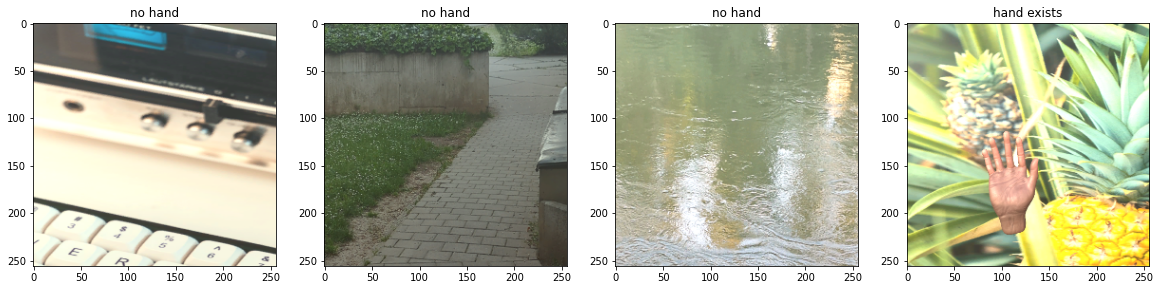

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(indexToClassName(batch[1][idx]))

# Build Neural Network Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [32]:
model = Sequential()

In [33]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Training the Neural Network

In [36]:
logdir='logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [38]:
hist = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[tensorboard_callback, earlystopping_callback])

Epoch 1/100
88/88 [==============================] - 170s 2s/step - loss: 0.6033 - accuracy: 0.6646 - val_loss: 0.3704 - val_accuracy: 0.8400


KeyboardInterrupt: 

# Performance Graphs

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Testing a single image

In [ ]:
import cv2 as opencv

In [ ]:
img = opencv.imread('Images/BinaryClassTestingFolder/FinalImageFolder/test/handExists/IMG_20220508_042243.jpg')
img = opencv.cvtColor(img, opencv.COLOR_BGR2RGB)
plt.imshow(img/255)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is handMissing')
else:
    print(f'Predicted class is handExists')

# Testing whole folder

In [ ]:
THRESHOLD = 0.5

imageCount = 0
correctCount = 0
falseCount = 0

currBatch = 0;

for batch in test_dataset.as_numpy_iterator():
    for idx, img in enumerate(batch[0]):
        print("image number " + str(BATCH_SIZE * currBatch + idx))
        plt.imshow(img)
        plt.show()

        yhat = model.predict(np.expand_dims(img, 0))
        print("predicted value is " + str(yhat))

        if(yhat > THRESHOLD and batch[1][idx] == 0):
            # predicted as handMissing but is handExists
            print("FALSE: predicted as handMissing but is handExists")
            falseCount += 1
        elif(yhat > THRESHOLD and batch[1][idx] == 1):
            # predicted as handMissing and is handMissing
            print("CORRECT: predicted as handMissing and is handMissing")
            correctCount += 1
        elif(yhat < THRESHOLD and batch[1][idx] == 0):
            # predicted as handExists and is handExists
            print("CORRECT: predicted as handExists and is handExists")
            correctCount += 1
        elif(yhat < THRESHOLD and batch[1][idx] == 1):
            # predicted as handExists but is handMissing
            print("FALSE: predicted as handExists but is handMissing")
            falseCount += 1

        imageCount += 1
        print("______________")
    currBatch += 1
    
print("Amount categorized: " + str(imageCount))
print("Correctly categorized: " + str(correctCount))
print("Falsely categorized: " + str(falseCount))
print("Ratio: " + str(correctCount / imageCount))

normalDetectionRatio = correctCount / imageCount

In [ ]:
normalDetectionRatio

## Testing different metrics
from https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce


In [ ]:
# Confusion Matrix

falsePositive = 0;
falseNegative = 0;
correctPositive = 0;
correctNegative = 0;

for batch in test_dataset.as_numpy_iterator():
    for idx, img in enumerate(batch[0]):
        yhat = model.predict(np.expand_dims(img, 0))
        if(yhat > THRESHOLD and batch[1][idx] == 0):
            falseNegative += 1
        elif(yhat > THRESHOLD and batch[1][idx] == 1):
            correctNegative += 1
        elif(yhat < THRESHOLD and batch[1][idx] == 0):
            correctPositive += 1
        elif(yhat < THRESHOLD and batch[1][idx] == 1):
            falsePositive += 1

print("Correctly classified positive: " + str(correctPositive))
print("Correctly classified negative: " + str(correctNegative))
print("Wrongly classified positive: " + str(falsePositive))
print("Wrongly classified negative: " + str(falseNegative))

In [ ]:
# Classification Accuracy

classificationAccuracy = correctCount / imageCount; classificationAccuracy

In [ ]:
# Precision

precisionHandExists = correctPositive / (correctPositive + falsePositive)
print("Precision for images with hands: " + str(precisionHandExists))
precisionHandMissing = correctNegative / (correctNegative + falseNegative)
print("Precision for images without hands: " + str(precisionHandMissing))

In [ ]:
# Recall

recall = correctPositive / (correctPositive + falseNegative); recall

In [ ]:
# F1 Score

f1Score = 2*precisionHandExists*recall / (precisionHandExists+recall); f1Score

In [ ]:
# Sensitivity

sensitivity = recall; sensitivity

In [ ]:
# Specificity

specificity = correctNegative / (correctNegative + falsePositive); specificity